In [1]:
from IPython.display import display 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import dateutil.parser
import statsmodels.api as sm

from yahoo_earnings_calendar import YahooEarningsCalendar
import akshare as ak



%matplotlib inline
sns.set_context(font_scale=2)

# Download SP500 component history
Downloading the top 300 takes about half an hour

In [66]:
# Get stock list (ordered by capital)
df_sp500_list = pd.read_csv('sp500_1_300_list.csv', header=None)

df_stocks = df_sp500_list[0].str.split('(').str[1].str[:-1]
stocks = list(df_stocks[df_stocks != 'GOOG'].values)

stocks += ['BABA', 'OHI']

# Get data
anom = []
df_stock_all = pd.DataFrame()
for stock_symbol in stocks:
    df_pe = ak.stock_us_fundamental(stock=stock_symbol, symbol="PE")
    df_pb = ak.stock_us_fundamental(stock=stock_symbol, symbol="PB")
    df_stock = pd.merge(df_pe, df_pb.drop('stock_price', axis=1), on='date')
    df_stock['stock'] = stock_symbol
    df_stock_all = df_stock_all.append(df_stock)
    print(f"{(stock_symbol, df_stock.date.min(), df_stock.date.max(), len(df_stock))}")
    if len(df_stock) < 30:
        anom.append(stock_symbol)
        
# df_stock_all.to_csv('sp500_1_300_history_raw.csv', index=False)

# Remove stocks with fewer than 29 quarters
df_stock_sub = df_stock_all[df_stock_all.stock.isin((df_stock_all.groupby('stock').size() >= 29).index.values)].copy()
df_stock_sub = get_quarter(df_stock_sub)
df_stock_sub = df_stock_sub.drop(['DATE', 'dayofyear', ], axis=1).sort_values(['date', 'stock'])

# df_stock_sub.to_csv('sp500_1_300_history_filterd.csv')

# Invest according to MA

In [3]:
# df = pd.read_csv('sp500.csv')
# https://fred.stlouisfed.org/series/SP500
df = pd.read_csv('sp500_19_20.csv', ); 
df.columns = ['Date', 'Close']; df = df[df.Close != '.']; df['Close'] = df['Close'].astype(float)

In [4]:
def get_invest(data, is_verbal=False):
    n_stock = 0.0
    Money = 100.0
    sign = 0
    for i in data.iterrows():
        sign = i[1]['sign_change']
        if i[0] == 0 or (sign == 1 and Money > 0):
            n_stock = Money / i[1]['Close']
            if is_verbal:
                print(f'''On {i[1]['Date']}, open price is {i[1]['Close']}, spend {Money:.1f} money to get {n_stock:.4f} stocks''')
            Money = 0.0
        if sign == -1 and n_stock > 0:
            Money = n_stock * i[1]['Close']
            n_stock = 0.0
            if is_verbal:
                print(f'''On {i[1]['Date']}, open price is {i[1]['Close']}, sell all stocks to get {Money:.1f} cash''')
    if is_verbal:
        print(f'''On {i[1]['Date']}, have {Money:.1f}, and {i[1]['Close'] * n_stock:.1f} worth of stock''')
    return Money + i[1]['Close'] * n_stock

In [238]:
# t1 = 10; t2 = 20

results_train = []
for t1 in range(5, 50, 5):
    for t2 in range(10, 100, 10):
        if t2 <= t1:
            continue
        # df['ma_t1'] = df.Close.rolling(t1).mean()
        # df['ma_t2'] = df.Close.rolling(t2).mean()
        df['ma_t1'] = df.Close.ewm(span=t1).mean()
        df['ma_t2'] = df.Close.ewm(span=t2).mean()

        df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
        df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
        df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

        dfp = df[(df.Date > '2018-12-31') & (df.Date <= '2019-12-31')].copy().reset_index(drop=True)

        results_train.append((get_invest(dfp), t1, t2))

In [239]:
results_test = []
for money_train, t1, t2 in sorted(results_train, reverse=True)[:20]:
    if t2 <= t1:
        continue
    # df['ma_t1'] = df.Close.rolling(t1).mean()
    # df['ma_t2'] = df.Close.rolling(t2).mean()
    df['ma_t1'] = df.Close.ewm(span=t1).mean()
    df['ma_t2'] = df.Close.ewm(span=t2).mean()

    df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
    df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
    df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

    dfp = df[df.Date > '2019-12-31'].copy().reset_index(drop=True)
    results_test.append((get_invest(dfp), t1, t2))

In [264]:
# sorted(results_test, reverse=True)[:20]

# sorted(results_train, reverse=True)[:20]

5 20
On 2019-01-02, close price is 2510.03, spend 100.0 money to get 0.0398 stocks
On 2019-05-08, close price is 2879.42, sell all stocks to get 114.7 cash
On 2019-06-07, close price is 2873.34, spend 114.7 money to get 0.0399 stocks
On 2019-08-01, close price is 2953.56, sell all stocks to get 117.9 cash
On 2019-09-04, close price is 2937.78, spend 117.9 money to get 0.0401 stocks
On 2019-10-01, close price is 2940.25, sell all stocks to get 118.0 cash
On 2019-10-15, close price is 2995.68, spend 118.0 money to get 0.0394 stocks
On 2020-01-31, close price is 3225.52, sell all stocks to get 127.1 cash
On 2020-02-04, close price is 3297.59, spend 127.1 money to get 0.0385 stocks
On 2020-02-24, close price is 3225.89, sell all stocks to get 124.3 cash
On 2020-04-08, close price is 2749.98, spend 124.3 money to get 0.0452 stocks
On 2020-06-26, close price is 3009.05, sell all stocks to get 136.0 cash
On 2020-07-01, close price is 3115.86, spend 136.0 money to get 0.0437 stocks
On 2020-09-

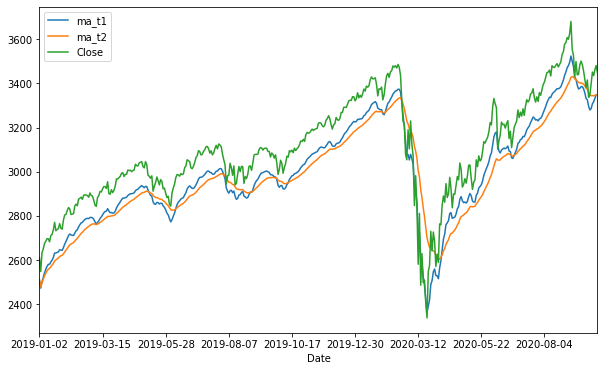

In [266]:
for money_train, t1, t2 in sorted(results_test, reverse=True)[:1]:
    if t2 <= t1:
        continue
    print(t1, t2)
    # df['ma_t1'] = df.Close.rolling(t1).mean()
    # df['ma_t2'] = df.Close.rolling(t2).mean()
    df['ma_t1'] = df.Close.ewm(span=t1).mean()
    df['ma_t2'] = df.Close.ewm(span=t2).mean()

    df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
    df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
    df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

    dfp = df.copy().reset_index(drop=True)
    print((get_invest(dfp, is_verbal=True), t1, t2))
        
f, a = plt.subplots(figsize=(10, 6))
dfp.Close = dfp.Close + 100
dfp = dfp.set_index('Date')
dfp[['ma_t1', 'ma_t2', 'Close']].plot(ax=a                        )

In [267]:
(dfp.Close.tail(1).values / dfp.Close.head(1).values * 100)[0]

132.12261928023815

# Auto-correlation of SP500

In [5]:
stock_us_daily_df = ak.stock_us_daily(symbol="SPY", adjust="")
print(stock_us_daily_df)

              open    high     low   close      volume        amount
date                                                                
1993-01-29   43.97   43.97   43.75   43.94   1003200.0  0.000000e+00
1993-02-01   43.97   44.25   43.97   44.25    480500.0  0.000000e+00
1993-02-02   44.22   44.38   44.13   44.34    201300.0  0.000000e+00
1993-02-03   44.41   44.84   44.38   44.81    529400.0  0.000000e+00
1993-02-04   44.97   45.09   44.88   45.00    531500.0  0.000000e+00
...            ...     ...     ...     ...         ...           ...
2021-02-08  389.27  390.56  388.35  390.51  33824169.0  6.975780e+10
2021-02-09  389.61  390.89  389.17  390.25  30656802.0  6.975780e+10
2021-02-10  392.12  392.28  387.50  390.08  53653085.0  6.975780e+10
2021-02-11  391.24  391.69  388.10  390.71  38790139.0  6.975780e+10
2021-02-12  389.85  392.90  389.77  392.64  39560743.0  6.975780e+10

[7056 rows x 6 columns]


In [6]:
df = stock_us_daily_df

price_type = 'close'
price_2020 = df.loc[(stock_us_daily_df.index.year == 2020) & (stock_us_daily_df.index.dayofyear <= 182), price_type]

In [143]:
w_len = len(price_2020)
corr = []
ds = []
ind = []
for i in range(0, len(df), 5):
    if i + w_len - 1 > len(df):
        break
    open_window = df.iloc[i:i+w_len, :][price_type]
    corr_v = np.corrcoef(price_2020, open_window)[0, 1]
    if corr_v > 0.7:
        ind.append(i)
        corr.append(corr_v)
        ds.append(open_window.index.values[0])

In [144]:
df_corr = pd.DataFrame([ind, ds, corr], index=['ind', 'date', 'corr']).T
n_days = 410

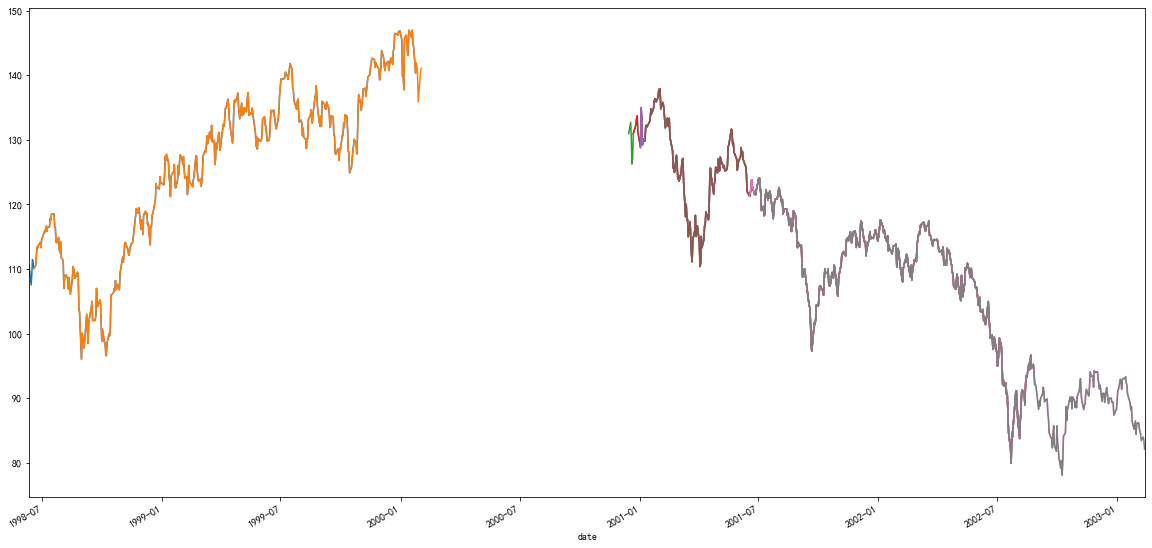

In [76]:
f, a = plt.subplots(figsize=(20, 10))
len_c = len(df_corr)
for i in df_corr.ind.values[:len_c // 4]:
    df.iloc[i:i+n_days, :][price_type].plot(ax=a)

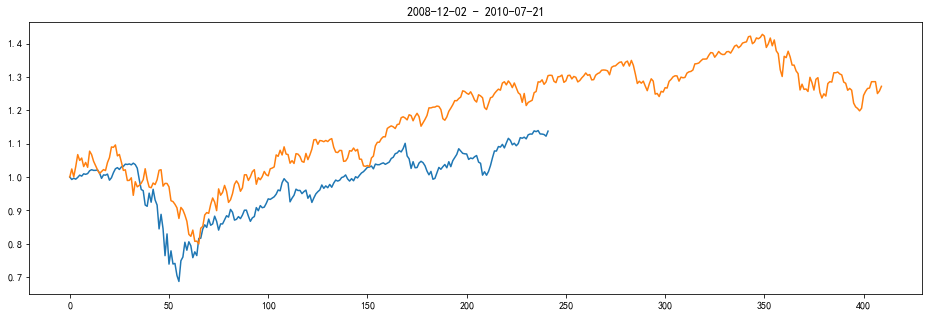

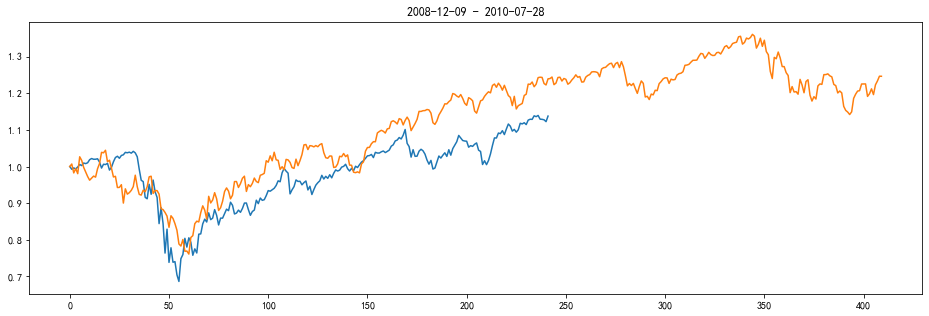

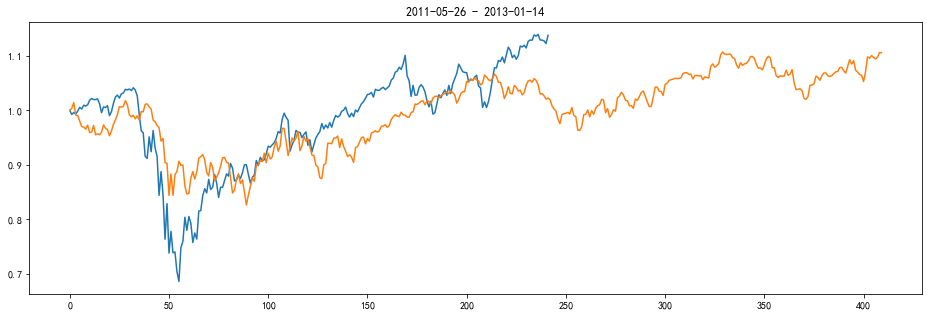

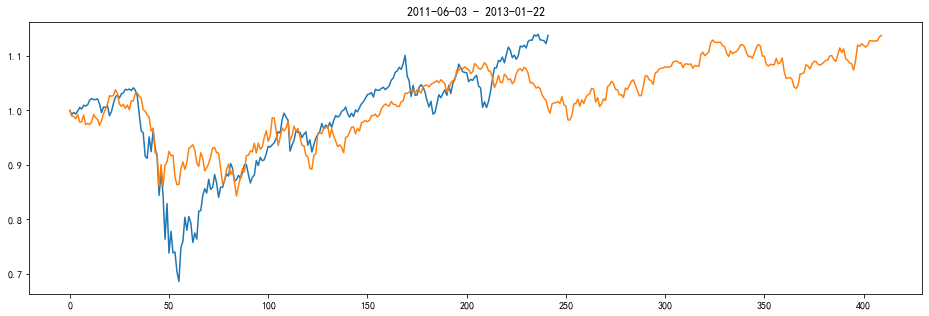

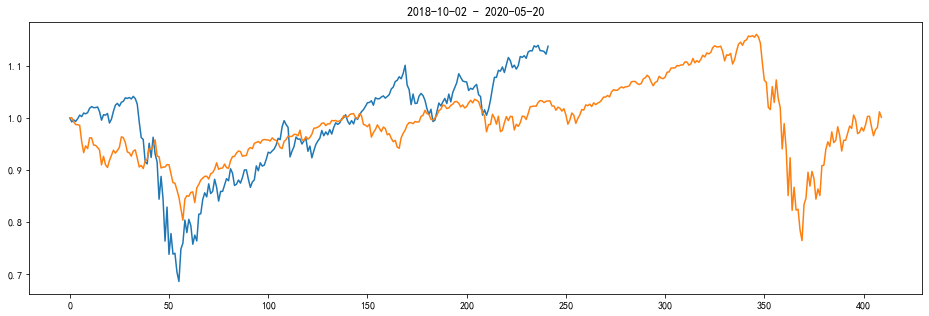

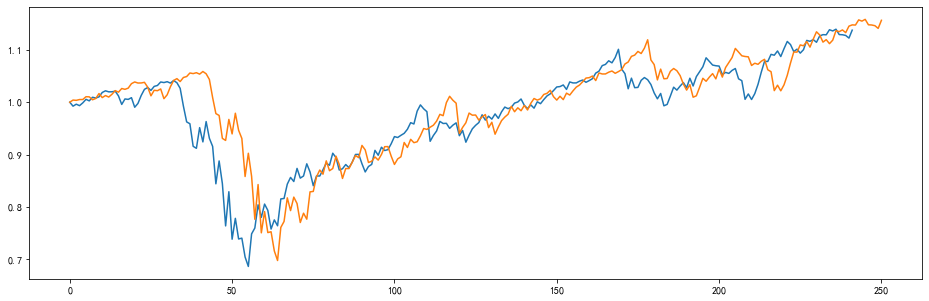

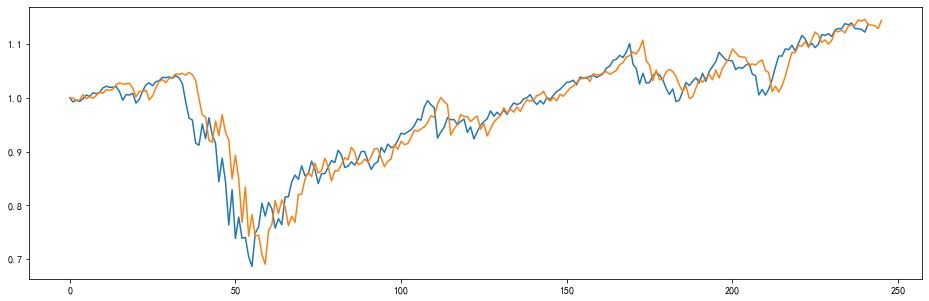

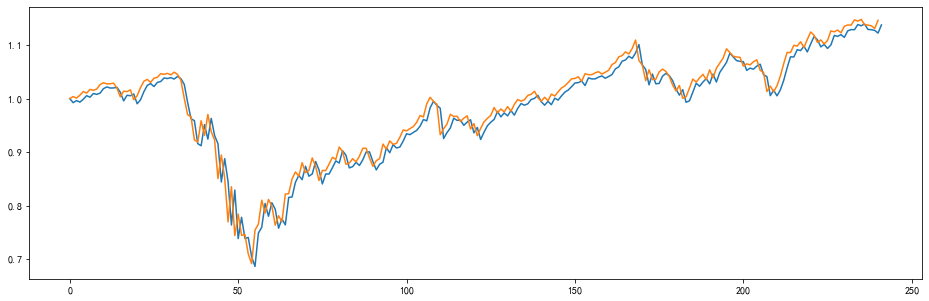

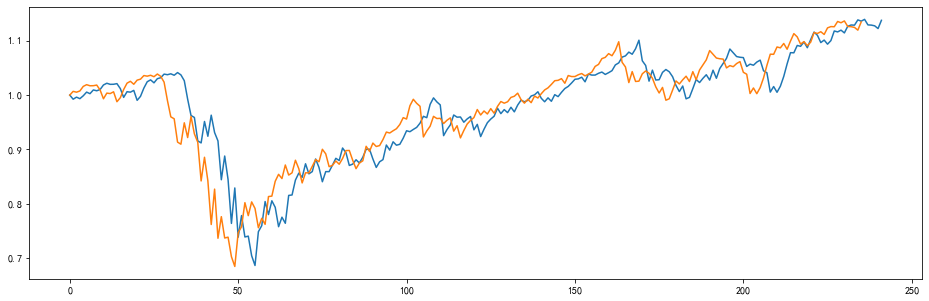

In [153]:
len_c = len(df_corr)
v0 = df.loc[(stock_us_daily_df.index.year == 2020), price_type].values.copy()
v0 = v0 / v0[0]
def plot_series(s, e):
    for i in df_corr.ind.values[s:e] :
        v1 = df.iloc[i:i+n_days, :][price_type].values.copy()
        v1 = v1 / v1[0]
        if v1[0] > v1[-1] or v1.min() > 0.85:
            continue
        f, a = plt.subplots(figsize=(16, 5))
        a.plot(v0)
        a.plot(v1)
        if i+n_days < len(df):
            a.set_title(f'{str(df.index[i].date())} - {str(df.index[i+n_days].date())}')
    
plot_series(s=0, e=len_c)

In [7]:
v0 = df.loc[df.index > pd.Timestamp('2020-01-01 00:00:00'), price_type]
v0 = v0 / v0.iloc[0]

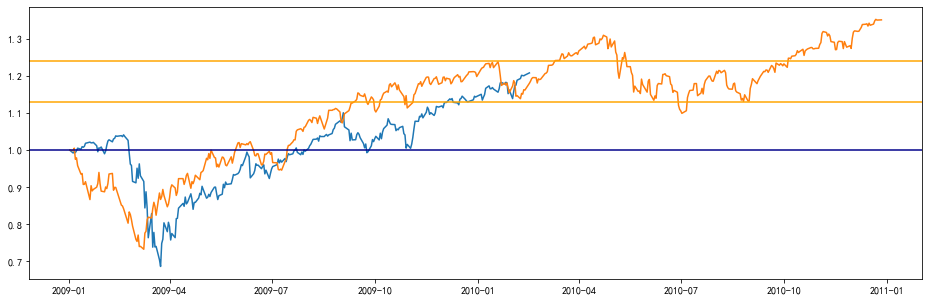

In [8]:
df_v1 = df.loc[(stock_us_daily_df.index.year.isin([2009, 2010])), price_type].iloc[:500].copy()
v1 = df_v1.values
v1 = v1 / v1[0]
f, a = plt.subplots(figsize=(16, 5))
a.plot(df_v1.index[:len(v0)], v0)
a.plot(df_v1.index, v1)
a.axhline(1.13, c='orange')
a.axhline(1.24, c='orange')
a.axhline(1.0, c='darkblue')


# Stock vs M2

In [18]:
symbol = "SPY"
stock_us_daily_df = ak.stock_us_daily(symbol=symbol, adjust="")
m2_weekly = pd.read_csv('WM2NS.csv')
m2_weekly['DATE'] = pd.to_datetime(m2_weekly['DATE'])

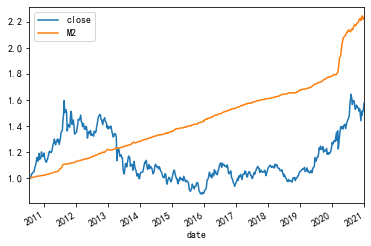

In [19]:
joined = stock_us_daily_df.join(m2_weekly.set_index('DATE')).dropna()
joined['close'] = joined['close'] / joined['close'].values[0]
joined['M2'] = joined['M2'] / joined['M2'].values[0]
joined[['close', 'M2']].plot()

# Regression to check if the price is too far away from M2 and Earning

Ideas from https://seekingalpha.com/article/4396638-visa-fair-price-and-upside-potential

## Functions and data

In [83]:
def parse_quarter(s):
    x = s.dayofyear
    if x <= 90:
        q = 'Q1'
    elif x <= 181:
        q = 'Q2'
    elif x <= 273:
        q = 'Q3'
    else:
        q = 'Q4'
    return str(s.year) + q
def get_quarter(df, date_column='date'):
    df['DATE'] = pd.to_datetime(df[date_column])
    df['dayofyear'] = df['DATE'].dt.dayofyear
    df.loc[df['DATE'].dt.is_leap_year, 'dayofyear'] -= 1
    df['year'] = df['DATE'].dt.year
    df['quarter'] = df.apply(parse_quarter, axis=1)
    df = df.set_index('quarter')
    df = df.sort_index()
    return df

def note_by_dev_strict(x):
    if x >= 0:
        return 'undervalued'
    else:
        return 'overvalued'

def note_by_dev(x):
    if x > 10:
        return 'undervalued'
    elif x < -10:
        return 'overvalued'
    else:
        return 'edge'

In [18]:
# old M2 From https://fred.stlouisfed.org/series/M2
# new M2, weekly non season-adjusted - https://fred.stlouisfed.org/series/WM2NS
m2_monthly = pd.read_csv('WM2NS.csv')
m2_monthly.columns = ['date', 'm2']

m2_monthly = get_quarter(m2_monthly)
m2_quarterly = m2_monthly.groupby(level=0)['m2'].mean()
# m2_quarterly = m2_quarterly[m2_quarterly.year >= 1981]

In [19]:
def get_stock_price(stock_symbol):
    
    # Get data and format date
    # Data from https://www.macrotrends.net/stocks/research
    stock_us_fundamental_df = ak.stock_us_fundamental(stock=stock_symbol, symbol="PE")
    stock_us_fundamental_df = get_quarter(stock_us_fundamental_df)
    stock_us_fundamental_df['stock'] = stock_symbol
    print(f"\n{stock_symbol}. Last quarter:\n{stock_us_fundamental_df.iloc[-2, :][['stock_price', 'ttm_net_eps']]}")
    
    # Cut the beginning to get full year
    if not stock_us_fundamental_df.index[0].endswith('Q1'):
        stock_us_fundamental_df = stock_us_fundamental_df[stock_us_fundamental_df.year > stock_us_fundamental_df.year[0]]

    # Get features
    stock_us_fundamental_df = stock_us_fundamental_df.join(m2_quarterly)
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].str[1:]
    stock_us_fundamental_df['ttm_net_eps'][stock_us_fundamental_df['ttm_net_eps'] == ''] = '0'
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].astype(float)
    
    stock_us_fundamental_df['ttm_net_eps_prev_q'] = stock_us_fundamental_df['ttm_net_eps'].shift(1)
    stock_us_fundamental_df['ttm_net_eps_delta'] = \
        stock_us_fundamental_df['ttm_net_eps'] - stock_us_fundamental_df['ttm_net_eps_prev_q']
    stock_us_fundamental_df['ttm_net_eps_delta_frac'] = \
        stock_us_fundamental_df['ttm_net_eps_delta'] / stock_us_fundamental_df['ttm_net_eps_prev_q']
    
    stock_us_fundamental_df['ttm_net_eps_norm'] = \
        stock_us_fundamental_df['ttm_net_eps'] / stock_us_fundamental_df['m2']

    # Get dep var
    stock_us_fundamental_df['price_next_q'] = stock_us_fundamental_df['stock_price'].shift(-1)
    stock_us_fundamental_df['price_next_q_log'] = stock_us_fundamental_df['price_next_q'].apply(np.log10)
    stock_us_fundamental_df['stock_price_log'] = stock_us_fundamental_df['stock_price'].apply(np.log10)

    return stock_us_fundamental_df

def plot_predictions(stock_us_fundamental_df, y_name, stock_name=''):
    f, a = plt.subplots(figsize=(20, 6))
#     stock_us_fundamental_df['m2_normalized'] = stock_us_fundamental_df['m2'] /\
#         stock_us_fundamental_df['m2'].mean() * stock_us_fundamental_df[y_name].mean()
#     stock_us_fundamental_df['ttm_net_eps_normalized'] = stock_us_fundamental_df['ttm_net_eps'] /\
#         stock_us_fundamental_df['ttm_net_eps'].mean() * stock_us_fundamental_df[y_name].mean()
    stock_us_fundamental_df[[y_name, 'predictions', 
    #                          'm2_normalized', 'ttm_net_eps_normalized'
                            ]].plot(ax=a)
    dates = stock_us_fundamental_df.index.values
    a.set_xticks(range(len(dates)))
    a.set_xticklabels(dates, rotation=40, ha='right')
    a.grid(which='major', alpha=0.5)
    a.set_title(stock_name)

## Modeling

In [20]:
eps_last_q = None #0.23 # ROST # AEP # 16 # TMO # 2.5 # ABT  #6.30  # MCD # 41 # AMZN
all_stocks = [
    'AEP', 'AMZN', 'BABA','CMCSA','FB', 'KO','NFLX','OHI', 'TMO',
#     'EXPE', 
    'GOOG', 'COST', 'WMT',  'MCD', 'SBUX', 
#     'EA', 
    'PG','AAPL','DIS',
#     'EDU','HPQ','LUV', 
    'MSFT',
#     'ROST','TSLA', 'TCEHY',
]
tgt_p = []
dfs = pd.DataFrame()

# coef_eps_neg = ['CMCSA', 'WMT', 'SBUX', 'PG', 'AAPL', 'EDU']: #


AEP. Last quarter:
stock_price    82.51
ttm_net_eps    $4.44
Name: 2020Q4, dtype: object


,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,77.64,80.32,3.85,97.803937,20.17
2020Q3,80.32,82.51,3.87,103.631705,20.75
2020Q4,82.51,85.89,4.44,109.318406,18.58


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     184.0
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           5.63e-26
Time:                        06:58:58   Log-Likelihood:                -160.92
No. Observations:                  51   AIC:                             329.8
Df Residuals:                      47   BIC:                             337.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -48.6529      4.687    -10.380      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,2758.82,3148.73,26.01,2501.295369,106.07
2020Q3,3148.73,3256.93,34.15,2951.324274,92.20
2020Q4,3256.93,3372.20,41.77,3360.255999,77.97


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     363.0
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.05e-29
Time:                        06:59:01   Log-Likelihood:                -328.10
No. Observations:                  51   AIC:                             662.2
Df Residuals:                      48   BIC:                             668.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1194.0536    123.700     -9.653      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,215.70,293.98,9.28,266.434056,23.24
2020Q3,293.98,232.73,6.97,260.206820,42.18
2020Q4,232.73,223.31,8.58,306.712327,27.12


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     8.728
Date:                Mon, 12 Apr 2021   Prob (F-statistic):            0.00301
Time:                        06:59:03   Log-Likelihood:                -65.257
No. Observations:                  15   AIC:                             138.5
Df Residuals:                      11   BIC:                             141.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -224.2546    236.449     -0.948      0.3

c:\users\yuwei\tools\env\penv\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))



CMCSA. Last quarter:
stock_price    51.92
ttm_net_eps    $2.28
Name: 2020Q4, dtype: object

COEF FOR EPS IS NEGATIVE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 



,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,38.43,45.60,2.49,55.911908,15.43
2020Q3,45.60,51.92,2.23,60.228967,20.45
2020Q4,51.92,53.57,2.28,63.262809,22.77


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     339.8
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           7.46e-32
Time:                        06:59:06   Log-Likelihood:                -118.55
No. Observations:                  51   AIC:                             245.1
Df Residuals:                      47   BIC:                             252.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.3936      2.380    -14.870      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,227.07,261.90,8.19,275.112374,27.73
2020Q3,261.90,273.16,8.78,297.380235,29.83
2020Q4,273.16,312.46,10.10,317.171233,27.05


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     65.24
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           2.12e-11
Time:                        06:59:08   Log-Likelihood:                -111.57
No. Observations:                  27   AIC:                             231.1
Df Residuals:                      23   BIC:                             236.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -252.7048     86.888     -2.908      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,43.61,48.58,2.12,59.194988,20.57
2020Q3,48.58,54.39,1.92,61.759816,25.30
2020Q4,54.39,53.18,1.79,63.935144,30.38


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     250.2
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           6.85e-29
Time:                        06:59:11   Log-Likelihood:                -116.35
No. Observations:                  51   AIC:                             240.7
Df Residuals:                      47   BIC:                             248.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.5918      2.185     -7.136      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,455.04,500.03,5.93,615.683493,76.74
2020Q3,500.03,540.73,6.20,649.514096,80.65
2020Q4,540.73,555.31,6.09,656.124385,88.79


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     127.9
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.29e-22
Time:                        06:59:14   Log-Likelihood:                -260.04
No. Observations:                  51   AIC:                             528.1
Df Residuals:                      47   BIC:                             535.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -222.3147     34.219     -6.497      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,27.96,28.74,1.72,40.886290,16.25
2020Q3,28.74,35.67,0.69,39.885412,41.65
2020Q4,35.67,37.59,0.69,42.114108,51.70


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     156.0
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.95e-24
Time:                        06:59:16   Log-Likelihood:                -121.88
No. Observations:                  51   AIC:                             251.8
Df Residuals:                      47   BIC:                             259.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.9814      1.806    -11.063      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,361.78,441.06,9.24,325.078330,39.15
2020Q3,441.06,465.51,12.20,430.609520,36.15
2020Q4,465.51,478.88,15.95,537.615832,29.19


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     200.4
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           8.85e-27
Time:                        06:59:19   Log-Likelihood:                -228.55
No. Observations:                  51   AIC:                             465.1
Df Residuals:                      47   BIC:                             472.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.9809     30.118     -3.486      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,1413.61,1469.60,45.47,1821.036513,31.09
2020Q3,1469.60,1751.88,51.75,1986.563939,28.40
2020Q4,1751.88,2285.88,58.70,2096.883927,29.84


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     40.19
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           2.08e-07
Time:                        06:59:21   Log-Likelihood:                -106.91
No. Observations:                  19   AIC:                             221.8
Df Residuals:                      15   BIC:                             225.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1970.1644    328.440     -5.999      0.0

c:\users\yuwei\tools\env\penv\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))



COST. Last quarter:
stock_price      331
ttm_net_eps    $9.78
Name: 2021Q1, dtype: object


,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,337.60,381.17,9.02,281.602380,37.43
2020Q4,381.17,331.00,9.74,311.426261,39.13
2021Q1,331.00,363.21,9.78,314.453773,33.84


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     482.8
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           2.67e-35
Time:                        06:59:23   Log-Likelihood:                -200.18
No. Observations:                  51   AIC:                             408.4
Df Residuals:                      47   BIC:                             416.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -45.4322     16.762     -2.710      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,127.86,137.66,6.27,121.851153,20.39
2020Q4,137.66,139.90,6.92,122.591400,19.89
2021Q1,139.90,139.78,4.73,121.182796,29.58


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     115.9
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.01e-21
Time:                        06:59:26   Log-Likelihood:                -174.47
No. Observations:                  51   AIC:                             356.9
Df Residuals:                      47   BIC:                             364.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.4276      6.855     -2.688      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,181.18,216.84,6.31,199.879937,28.71
2020Q3,216.84,213.25,6.55,214.821519,33.11
2020Q4,213.25,231.48,6.31,221.189455,33.79


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     154.9
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           2.28e-24
Time:                        06:59:27   Log-Likelihood:                -208.06
No. Observations:                  51   AIC:                             424.1
Df Residuals:                      47   BIC:                             431.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -108.6968      9.962    -10.912      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,72.53,85.14,1.11,100.006658,65.34
2020Q3,85.14,106.52,0.77,106.991024,110.58
2020Q4,106.52,113.18,0.56,112.880213,190.22


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     203.9
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           6.12e-27
Time:                        06:59:29   Log-Likelihood:                -164.57
No. Observations:                  51   AIC:                             337.1
Df Residuals:                      47   BIC:                             344.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -68.3017      9.576     -7.132      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,117.46,137.39,4.96,118.510698,23.68
2020Q3,137.39,138.31,5.23,116.380950,26.27
2020Q4,138.31,136.37,5.29,120.643841,26.14


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     109.0
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           3.56e-21
Time:                        06:59:31   Log-Likelihood:                -174.27
No. Observations:                  51   AIC:                             356.5
Df Residuals:                      47   BIC:                             364.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4676      7.507     -0.728      0.4

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,90.74,115.44,3.29,71.439409,27.60
2020Q3,115.44,132.49,3.26,75.682082,35.41
2020Q4,132.49,133.00,3.69,84.894583,35.88


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     142.1
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.42e-23
Time:                        06:59:33   Log-Likelihood:                -157.44
No. Observations:                  51   AIC:                             322.9
Df Residuals:                      47   BIC:                             330.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -62.7669     12.007     -5.228      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,111.51,124.08,-0.62,113.167173,0.0
2020Q3,124.08,181.18,-1.59,115.689795,0.0
2020Q4,181.18,187.89,-2.74,115.923554,0.0


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     281.9
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           2.95e-27
Time:                        06:59:36   Log-Likelihood:                -191.03
No. Observations:                  51   AIC:                             388.1
Df Residuals:                      48   BIC:                             393.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -66.9697     13.031     -5.139      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,202.02,209.29,5.75,168.039256,35.13
2020Q3,209.29,221.91,6.19,182.307220,33.81
2020Q4,221.91,255.85,6.71,195.968333,33.07


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     93.95
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           7.20e-20
Time:                        06:59:38   Log-Likelihood:                -208.31
No. Observations:                  51   AIC:                             424.6
Df Residuals:                      47   BIC:                             432.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -102.9312      9.864    -10.435      0.0

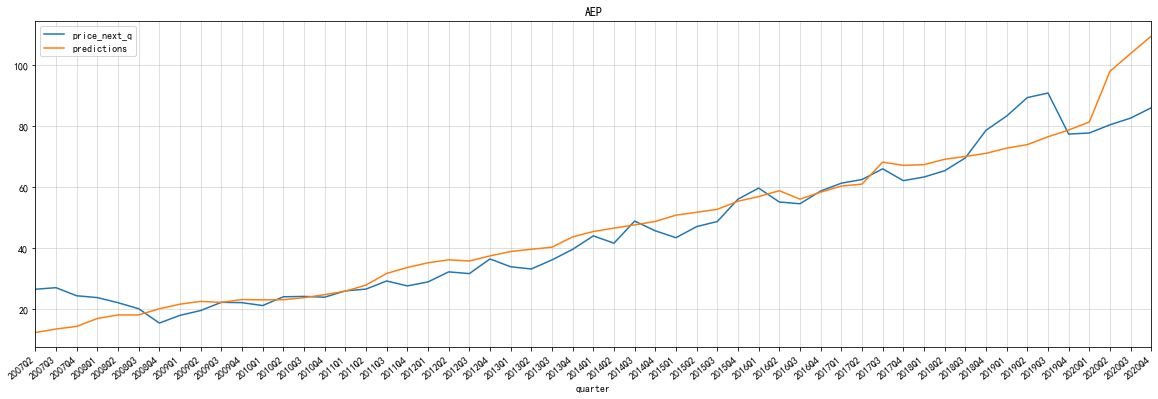

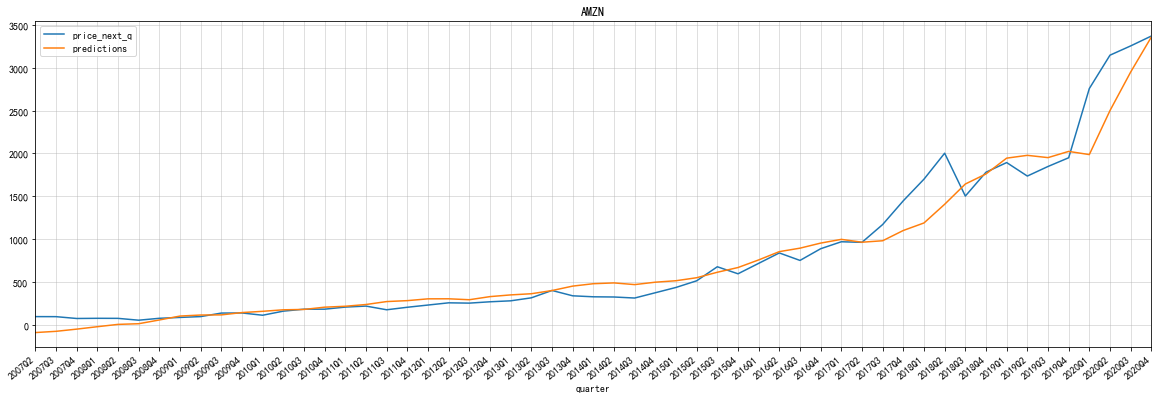

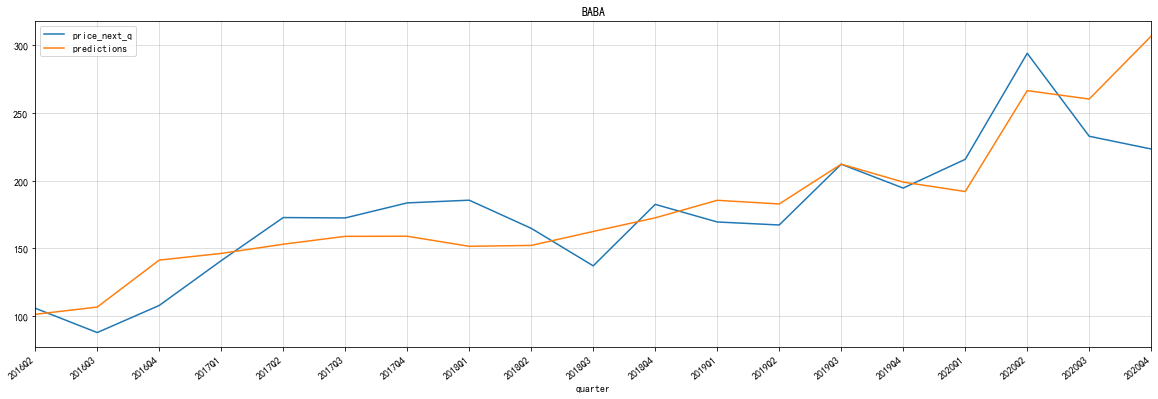

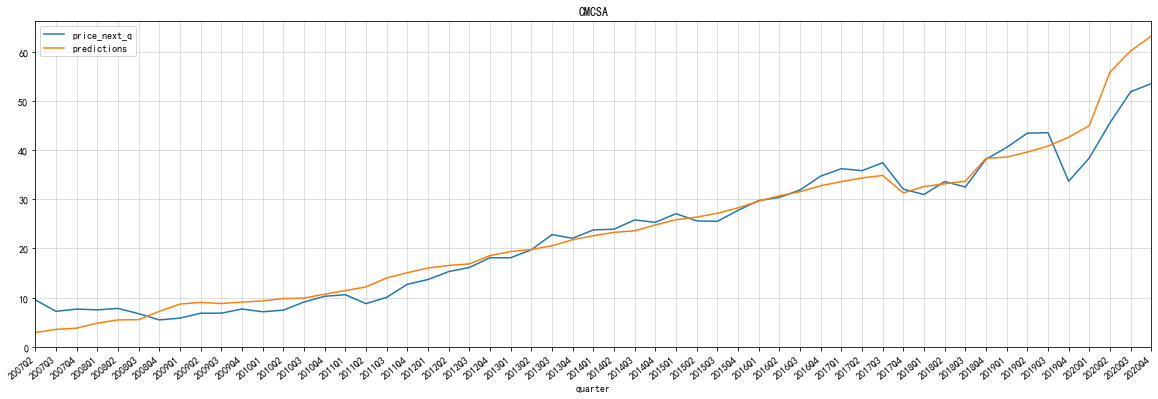

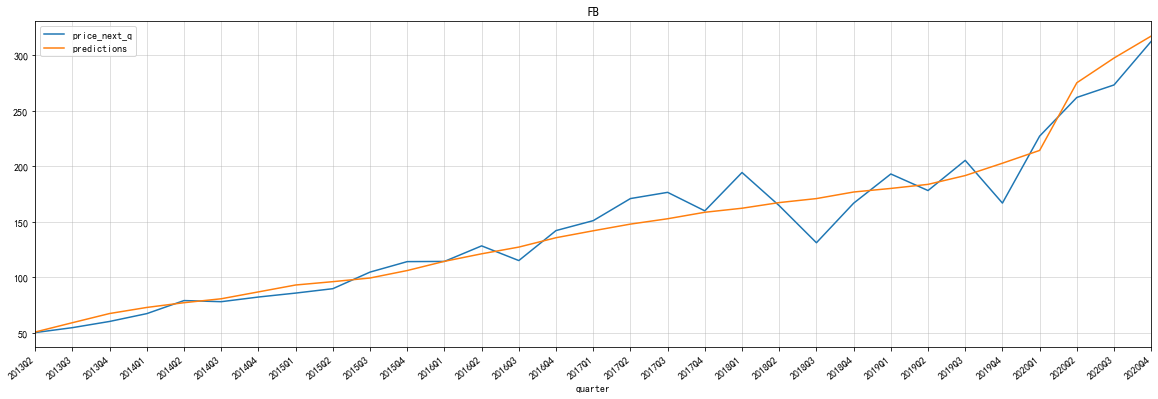

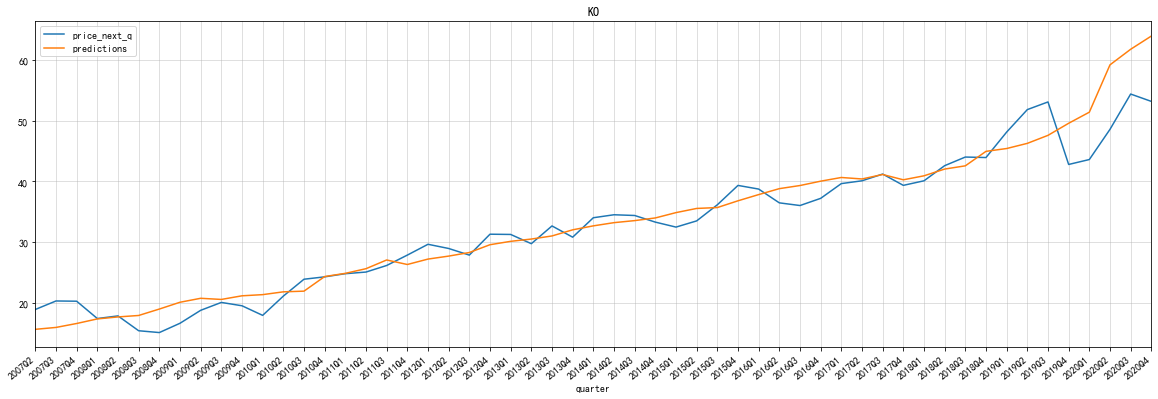

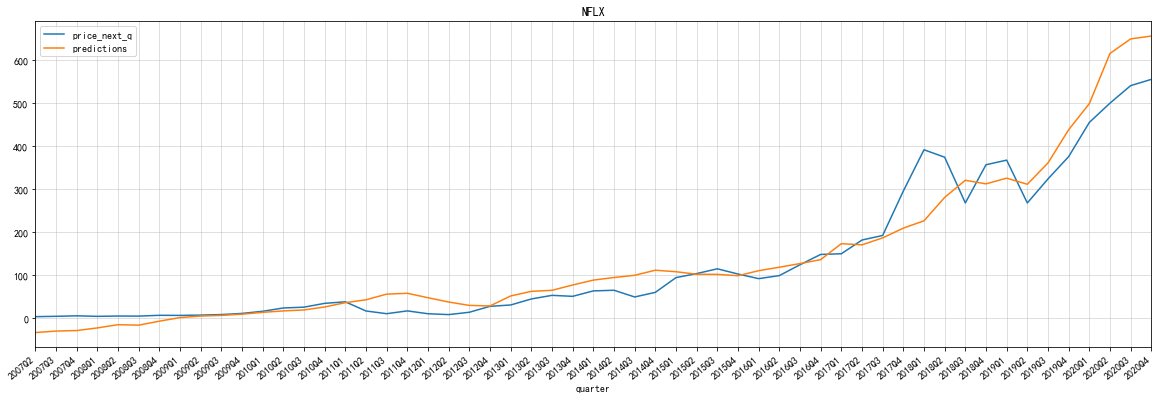

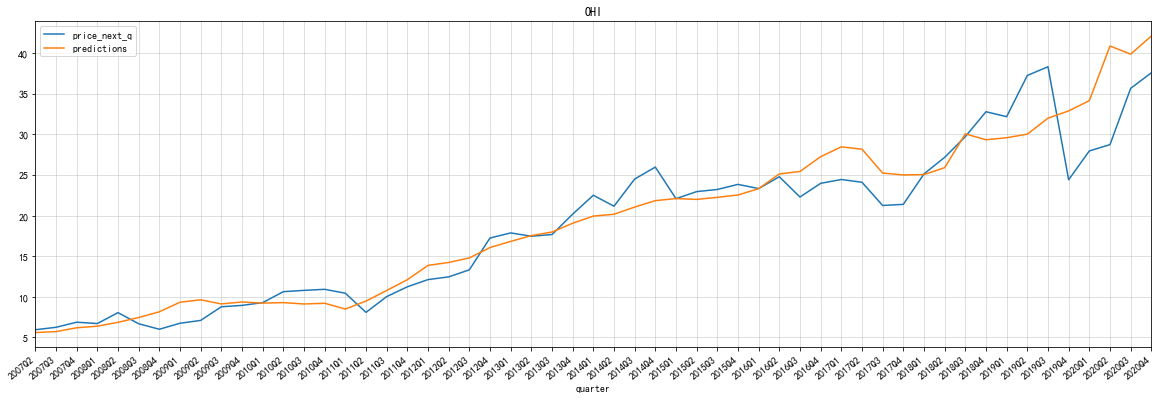

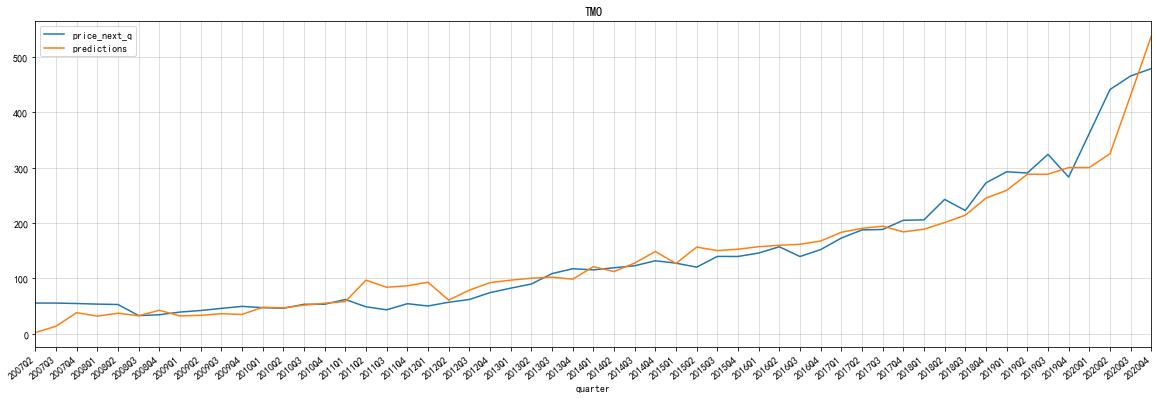

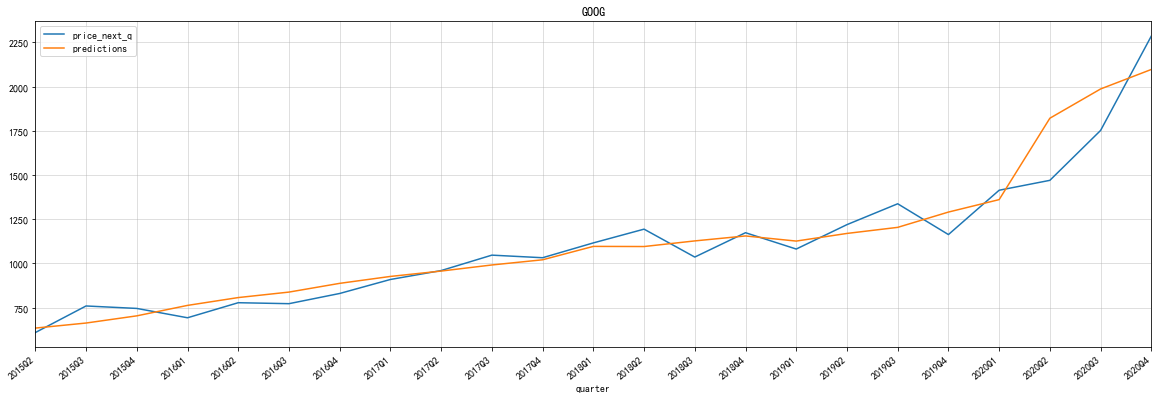

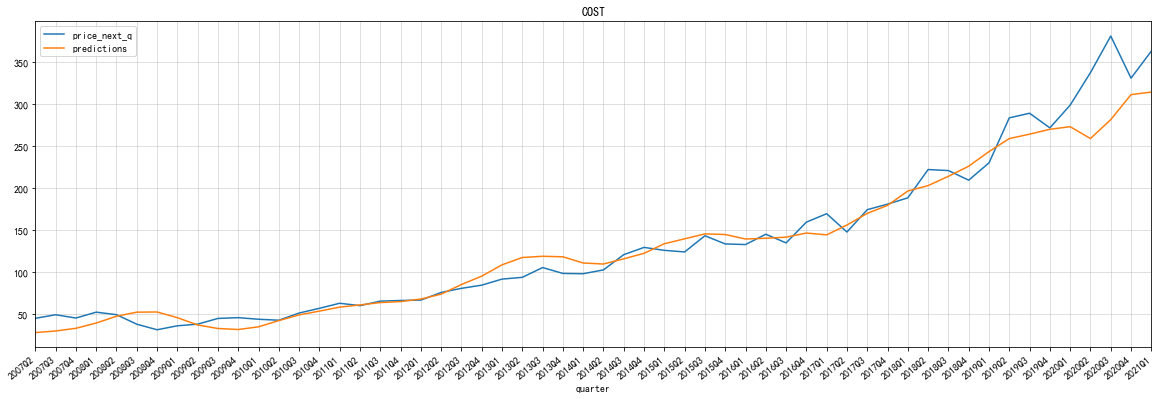

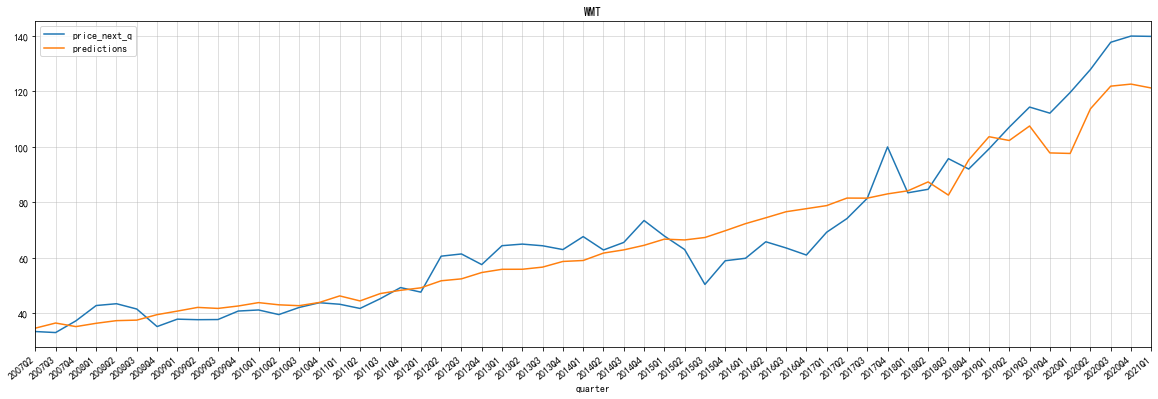

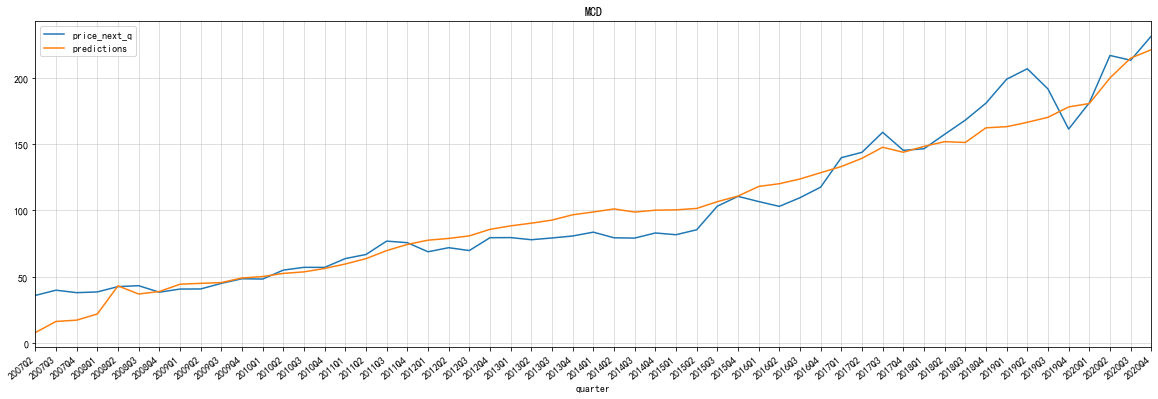

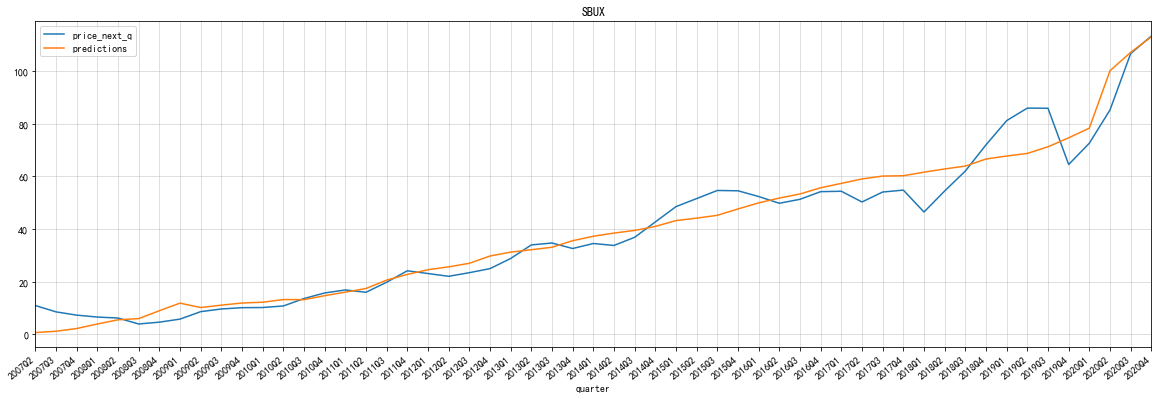

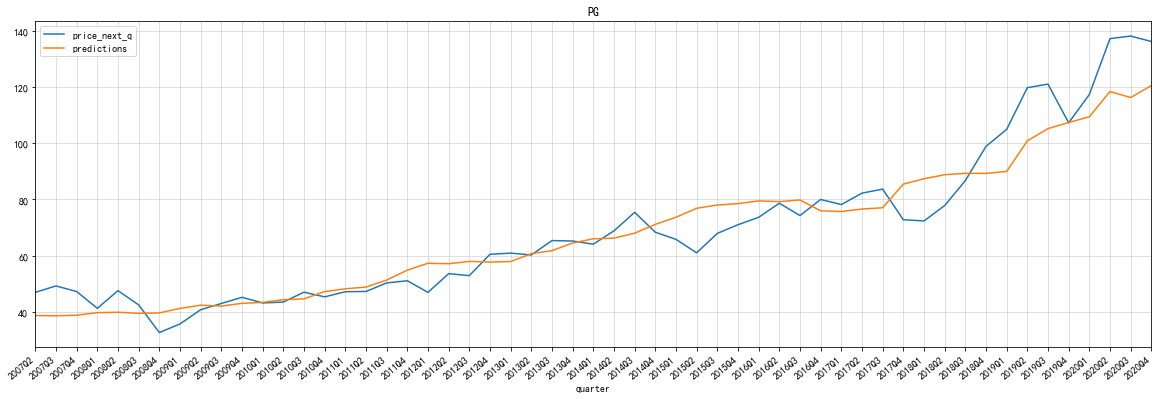

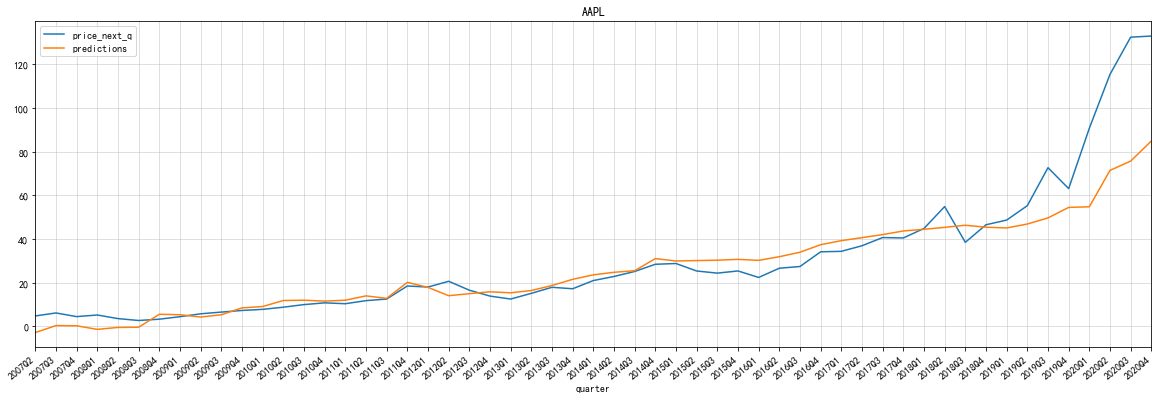

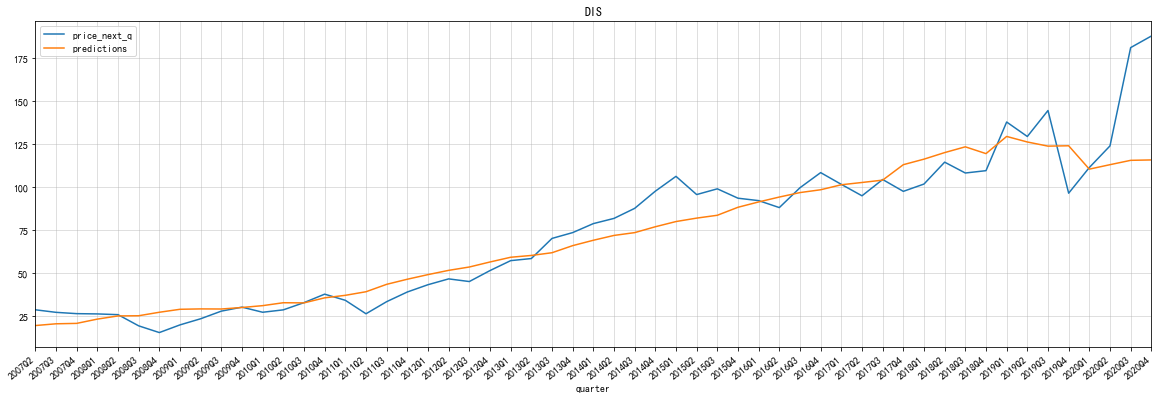

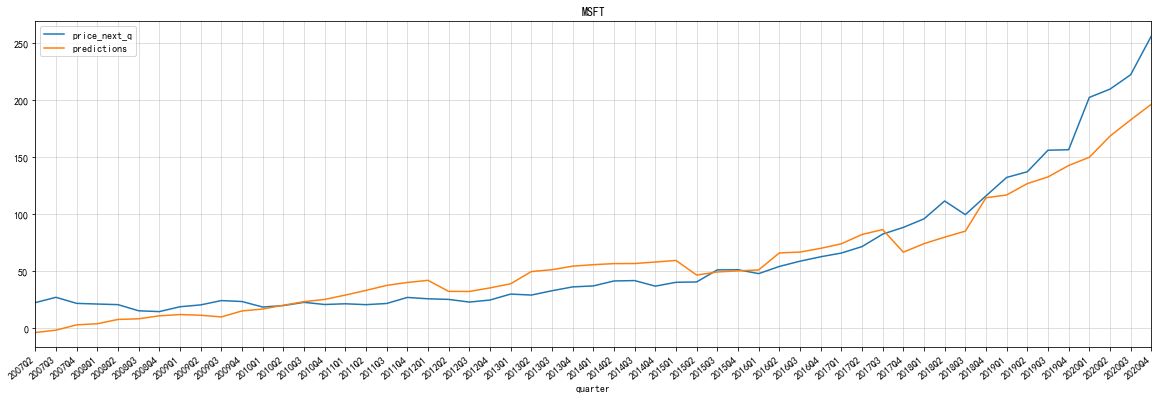

In [6]:
# df[['ttm_net_eps_delta', 'price_next_q', 'ttm_net_eps', 'pe_ratio']].corr()
# df[['ttm_net_eps_delta', 'pe_ratio']].plot()
# df[['ttm_net_eps_delta', 'price_next_q', 'ttm_net_eps']].hist()

# eps_last_q of some stocks is not accurate
for stock_symbol in all_stocks:
    df = get_stock_price(stock_symbol)  

    # Change values manually for corrected ER
    if eps_last_q:
        df.iloc[-2, 1] = eps_last_q
        print('OVERWRITE LAST QUARTER TTM_NET_EPS!!!!!!!!!!!!!\n')

    pe_current = df['pe_ratio'].values[-1]
    pe_median = df['pe_ratio'].median()
    pe_current_to_median = pe_current / pe_median 
    # The first row doesn't have prev quarter earning. 
    # The last row is the day when data is pulled
    df = df.iloc[1:-1, :]
    # print(df.tail())

    feature_name = [
        'ttm_net_eps', 
        'm2',
    #     'ttm_net_eps_norm'
    #     'ttm_net_eps_delta',
    #     'pe_ratio',
    ]
    # Use growth rate only if all earnings are positive
    if all(df['ttm_net_eps'] > 0):
        feature_name.append('ttm_net_eps_delta_frac')
        
    y_list = ['price_next_q', 'stock_price']
    y_name = y_list[0]

    # Remove 2020 when training models
    df_train = df[df.year < 2020]

    X = sm.add_constant(df_train[feature_name].values)
    y = df_train[y_name].values
    model = sm.OLS(y, X).fit()

    
#     mod = sm.ols(formula=f'{y_name} ~ ttm_net_eps + m2', data=df_train)
#     model = mod.fit()
    
    X_pred = sm.add_constant(df[feature_name].values)
    df['predictions'] = model.predict(X_pred)
    if model.params[1] < 0:
        print('\nCOEF FOR EPS IS NEGATIVE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n')
    display(df[['stock_price', 'price_next_q', 'ttm_net_eps', 'predictions', 'pe_ratio']].tail(3))
    print(model.summary())
#     print(f"""Adj. R^2: {model.rsquared_adj:.2}  P-values: {[round(i, 3) for i in model.pvalues[1:]]}""")

    tgt_p.append((stock_symbol, 
                  df['price_next_q'].values[-1].round(), 
                  df['predictions'].values[-1].round(),
                  model.rsquared_adj.round(2),
                  pe_current, 
                  pe_current_to_median,
                  int(model.params[1] < 0),
                 ))
    # The last row for price_next_q is the CURRENT PRICE
    plot_predictions(df, y_name, stock_symbol)
    dfs = pd.concat([dfs, df])
    print('____________________________________________________________________________________')

#### Additional data for the stock

In [53]:
# plot_predictions(df.iloc[:-12, :], y_name, stock_symbol)

#### Get note for under/over value

In [7]:
df_p = pd.DataFrame(tgt_p, columns=['stock', 'p_current', 'p_predict', 
                                    'rsquare_adj', 'pe_current', 'pe_current_to_median', 'is_eps_coef_neg'])
df_p['dev%'] = ((df_p['p_predict'] / df_p['p_current'] - 1) * 100).round()

df_p['note'] = df_p['dev%'].apply(note_by_dev)

df_p.to_csv('tgt_price.csv', index=False)

# df_p[df_p.is_eps_coef_neg == 1].stock.values

In [8]:
for k, v in df_p.groupby('note'):
    display(v.sort_values('stock'))

,stock,p_current,p_predict,rsquare_adj,pe_current,pe_current_to_median,is_eps_coef_neg,dev%,note
1,AMZN,3372.0,3360.0,0.94,80.73,0.976061,0,-0.0,edge
4,FB,312.0,317.0,0.88,30.94,0.876736,0,2.0,edge
9,GOOG,2286.0,2097.0,0.87,38.94,1.369198,1,-8.0,edge
12,MCD,231.0,221.0,0.90,36.68,2.087649,0,-4.0,edge
13,SBUX,113.0,113.0,0.92,202.11,7.600978,1,0.0,edge


,stock,p_current,p_predict,rsquare_adj,pe_current,pe_current_to_median,is_eps_coef_neg,dev%,note
15,AAPL,133.0,85.0,0.89,36.02,2.307495,1,-36.0,overvalued
10,COST,363.0,314.0,0.97,37.14,1.682446,0,-13.0,overvalued
16,DIS,188.0,116.0,0.92,0.00,0.000000,0,-38.0,overvalued
17,MSFT,256.0,196.0,0.85,38.13,2.523494,0,-23.0,overvalued
14,PG,136.0,121.0,0.87,25.78,1.691601,1,-11.0,overvalued
11,WMT,140.0,121.0,0.87,29.55,2.289810,1,-14.0,overvalued


,stock,p_current,p_predict,rsquare_adj,pe_current,pe_current_to_median,is_eps_coef_neg,dev%,note
0,AEP,86.0,109.0,0.92,19.34,1.586546,0,27.0,undervalued
2,BABA,223.0,307.0,0.62,26.03,0.701996,0,38.0,undervalued
3,CMCSA,54.0,63.0,0.95,23.50,1.504481,1,17.0,undervalued
5,KO,53.0,64.0,0.94,29.71,1.727326,0,21.0,undervalued
6,NFLX,555.0,656.0,0.88,91.18,1.066433,0,18.0,undervalued
7,OHI,38.0,42.0,0.90,54.48,3.736626,0,11.0,undervalued
8,TMO,479.0,538.0,0.92,30.02,1.062655,0,12.0,undervalued


## Experiment invest stratege

In [233]:
# dfs.groupby('stock').year.min()
# remove stocks with short history
dfsa = dfs[~dfs.stock.isin(['BABA', 'FB', 'CMCSA', 'GOOG', 'TSLA', # too short
                            'COST', 'WMT', # weird q timing
#                             'AAPL', 'SBUX', 'PG',  # eps coef neg
                           ])].copy()


year_cut = 2009
method = note_by_dev  # note_by_dev_strict results are worse
CASH_QUARTERLY = 1000

dfsa = dfsa[dfsa.year >= year_cut]
dfsa['dev%'] = ((dfsa['predictions'] / dfsa['price_next_q'] - 1) * 100).round()
dfsa['note'] = dfsa['dev%'].apply(method)

rsl = pd.DataFrame()

#### Method 1 - invest on undervalued

In [234]:
# Compute total shares bought
dfsa_under = dfsa[dfsa.note == 'undervalued'].copy()
dfsa_under = dfsa_under.join(dfsa_under.groupby(level=0).size().rename('split'))
dfsa_under['dollars_bought'] = CASH_QUARTERLY / dfsa_under['split']
dfsa_under['shares_bought'] = dfsa_under['dollars_bought'] / dfsa_under['stock_price']

def get_values(df):
    df_shares_total = df.groupby('stock', as_index=False).shares_bought.sum()
    df_shares_total = pd.merge(df_shares_total, dfsa[dfsa.index == df.index.max()][['stock', 'stock_price']], on='stock')
    df_shares_total['value'] = df_shares_total['stock_price'] * df_shares_total['shares_bought']
    return df_shares_total

for q in dfsa_under.index.unique().values:
    if q.endswith('Q4'):
        g = dfsa_under[dfsa_under.index <= q]
        df_shares_total = get_values(g)
        rsl = rsl.append(pd.DataFrame([q, g.index.nunique() * CASH_QUARTERLY, df_shares_total['value'].sum(), '1'],
                                      index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {q} - cost: {g.index.nunique() * CASH_QUARTERLY}; value: {df_shares_total['value'].sum():.0f}")

#### Method 1.5 - invest on undervalued, sell overvalued

In [235]:
CASH_QUARTERLY_IF_INVEST_ALL = CASH_QUARTERLY * dfsa_under.index.nunique() / dfsa.index.nunique()

In [236]:
stock_shares = {}
cash_residual = 0
cost = 0
for k, g in dfsa.groupby(level=0):
    overvalued = g[g.note == 'overvalued']
    undervalued = g[g.note == 'undervalued']

    # Get initial cash for this quarter = new money + residual from last time
    cash_residual += CASH_QUARTERLY_IF_INVEST_ALL

#     print(k)
#     if not overvalued.empty:
#         print(f'Sell {overvalued.stock.values} if any')
#     print(f'cash_residual: {cash_residual}')
#     if not undervalued.empty:
#         print(f'Buy {undervalued.stock.values}')
        
    # Buy undervalued if any; Sell overvalued only if there are something to buy
    if len(undervalued) > 0:
        # Sell overvalued
        for _, row in overvalued.iterrows():
            cash_residual += stock_shares.pop(row['stock'], 0) * row['stock_price']
        # Buy undervalued
        dollars_bought = cash_residual / len(undervalued)
        for _, row in undervalued.iterrows():
            stock_shares[row['stock']] = stock_shares.get(row['stock'], 0) + dollars_bought / row['stock_price']
        cash_residual = 0
        
    if k.endswith('Q4'):
        cost += CASH_QUARTERLY_IF_INVEST_ALL * 4 
        rsl = rsl.append(pd.DataFrame([k, cost, 
                                       cash_residual + sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0], '1.5'],
                              index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {k} - cost: {cost:.0f}; stock value: {sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0]:.0f}",
#              f"cash: {cash_residual}")

#### Method 1.8 - nvest on undervalued, sell if 10% lower than previous quarter

In [237]:
stock_shares = {}
prev = None
cash_residual = 0
cost = 0
for k, g in dfsa.groupby(level=0):
    undervalued = g[g.note == 'undervalued']

    # Get initial cash for this quarter = new money + residual from last time
    cash_residual += CASH_QUARTERLY_IF_INVEST_ALL

#     print(k)
#     if not overvalued.empty:
#         print(f'Sell {overvalued.stock.values} if any')
#     print(f'cash_residual: {cash_residual}')
#     if not undervalued.empty:
#         print(f'Buy {undervalued.stock.values}')
        
    # Sell if 10% off then previous
    if k > dfsa.index.min():
        merged = pd.merge(prev[['stock', 'stock_price']], g[['stock', 'stock_price']], on='stock', suffixes=('_prev', ''))
        merged['frac_change'] = merged['stock_price'] / merged['stock_price_prev'] - 1
        stocks_to_buy = merged[merged['frac_change'] < -0.1][['stock', 'stock_price']]
        if not stocks_to_buy.empty:
            for s, p in stocks_to_buy.values:
                cash_residual += stock_shares.pop(s, 0) * p
            print(f'On {k}, sell {stocks_to_buy.stock.values}. Cash: {cash_residual}')

    # Buy undervalued if any
    if len(undervalued) > 0:
        # Buy undervalued
        dollars_bought = cash_residual / len(undervalued)
        for _, row in undervalued.iterrows():
            stock_shares[row['stock']] = stock_shares.get(row['stock'], 0) + dollars_bought / row['stock_price']
        cash_residual = 0
    
    prev = g
    
    if k.endswith('Q4'):
        cost += CASH_QUARTERLY_IF_INVEST_ALL * 4 
        rsl = rsl.append(pd.DataFrame([k, cost, 
                                       cash_residual + sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0], '1.8'],
                              index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {k} - cost: {cost:.0f}; stock value: {sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0]:.0f}",
#              f"cash: {cash_residual}")

On 2010Q2, sell ['AMZN' 'MSFT']. Cash: 1499.3925656733395
On 2011Q3, sell ['NFLX' 'OHI' 'TMO' 'DIS']. Cash: 2818.347942134671
On 2011Q4, sell ['AMZN' 'NFLX' 'TMO']. Cash: 2715.797281589773
On 2012Q2, sell ['NFLX']. Cash: 1468.8631317344323
On 2012Q3, sell ['NFLX']. Cash: 1125.2593509333024
On 2012Q4, sell ['AAPL']. Cash: 7104.863289500094
On 2013Q1, sell ['AAPL']. Cash: 2147.064697266642
On 2014Q1, sell ['AMZN']. Cash: 5136.781731643578
On 2014Q4, sell ['NFLX']. Cash: 4299.247325014469
On 2015Q1, sell ['MSFT']. Cash: 10965.493931816985
On 2015Q2, sell ['OHI']. Cash: 1772.389931288527
On 2015Q3, sell ['AAPL']. Cash: 3618.4785906690004
On 2016Q1, sell ['AMZN' 'NFLX']. Cash: 13285.233794851625
On 2016Q2, sell ['NFLX' 'AAPL']. Cash: 10719.893188395807
On 2016Q4, sell ['AMZN' 'OHI' 'TMO']. Cash: 8850.976942275238
On 2017Q4, sell ['OHI']. Cash: 6089.4642242848095
On 2018Q1, sell ['PG']. Cash: 7984.575286620551
On 2018Q2, sell ['SBUX']. Cash: 20744.206147767236
On 2018Q4, sell ['AMZN' 'NFLX' 

#### Method 2 - invest on all but only at times when some stocks are under

In [239]:
dfsa_same_time = dfsa[dfsa.index.isin(dfsa_under.index.unique().values)].copy()
dfsa_same_time['dollars_bought'] = CASH_QUARTERLY / dfsa_same_time.stock.nunique()
dfsa_same_time['shares_bought'] = dfsa_same_time['dollars_bought'] / dfsa_same_time['stock_price']

for q in dfsa_same_time.index.unique().values:
    if q.endswith('Q4'):
        g = dfsa_same_time[dfsa_same_time.index <= q]
        df_shares_total = get_values(g)
        rsl = rsl.append(pd.DataFrame([q, g.index.nunique() * CASH_QUARTERLY, df_shares_total['value'].sum(), '2'],
                                      index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {q} - cost: {g.index.nunique() * CASH_QUARTERLY}; value: {df_shares_total['value'].sum():.0f}")

#### method 3 - invest on all over all itime

In [240]:
dfsa['dollars_bought'] = CASH_QUARTERLY_IF_INVEST_ALL / dfsa.stock.nunique()
dfsa['shares_bought'] = dfsa['dollars_bought'] / dfsa['stock_price']

for q in dfsa.index.unique().values:
    if q.endswith('Q4'):
        g = dfsa[dfsa.index <= q]
        df_shares_total = get_values(g)
        rsl = rsl.append(pd.DataFrame([q, g.index.nunique() * CASH_QUARTERLY_IF_INVEST_ALL, df_shares_total['value'].sum(), '3'],
                                      index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {q} - cost: {g.index.nunique() *  CASH_QUARTERLY_IF_INVEST_ALL:.0f}; value: {df_shares_total['value'].sum():.0f}")

### summary

In [241]:
rslp = rsl.pivot(index='year', columns='method', values=['cost', 'value'])

tmp = pd.DataFrame()
for i in rslp['value']:
    tmp = pd.concat([tmp, rslp['value'][i] / rslp['value']['1'].rename(i)], axis=1, sort=False)
tmp.columns = pd.MultiIndex.from_product([["frac"], tmp.columns])

pd.concat([rslp, tmp], axis=1).T

year            2009Q4    2010Q4    2011Q4    2012Q4    2013Q4    2014Q4  \
      method                                                               
cost  1           4000      8000     12000     16000     20000     24000   
      1.5      3833.33   7666.67     11500   15333.3   19166.7     23000   
      1.8      3833.33   7666.67     11500   15333.3   19166.7     23000   
      2           4000      8000     12000     16000     20000     24000   
      3        3833.33   7666.67     11500   15333.3   19166.7     23000   
value 1        5176.07   11600.3     18020   26808.8   44038.4   53882.1   
      1.5      4830.97   10956.2   17512.2   26721.9   48107.2   55094.2   
      1.8       4960.4   10914.5   16741.5   24290.7   40509.8   49390.9   
      2        5058.04   11666.8   15697.9   23076.7   40132.4   48987.2   
      3        4847.29   11180.7   15043.8   22115.2   38460.3     46946   
frac  1              1         1         1         1         1         1   
      1.5     0.933328   0.94447  0.971823  0.996759   1.09239   1.02249   
      1.8     0.958333  0.940879  0.929053  0.906072  0.919874  0.916647   
      2       0.977197   1.00573  0.871137  0.860787  0.911305  0.909154   
      3       0.936481  0.963828   0.83484  0.824921  0.873334  0.871273   

year            2015Q4    2016Q4    2017Q4   2018Q4    2019Q4    2020Q4  
      method                                                             
cost  1          28000     32000     36000      NaN     42000     46000  
      1.5      26833.3   30666.7     34500  38333.3   42166.7     46000  
      1.8      26833.3   30666.7     34500  38333.3   42166.7     46000  
      2          28000     32000     36000      NaN     42000     46000  
      3        26833.3   30666.7     34500  38333.3   42166.7     46000  
value 1        79141.2   87862.3    122540      NaN    209233    320563  
      1.5      91704.2    105965    143278   174329    202493    320274  
      1.8      69153.1   73199.3   95311.8   109253    132209    171375  
      2        71100.9   79128.1    110062      NaN    184163    273693  
      3        68138.4   75831.1    105476   130877    178948    265543  
frac  1              1         1         1      NaN         1         1  
      1.5      1.15874   1.20603   1.16923      NaN  0.967789  0.999096  
      1.8     0.873793  0.833114  0.777801      NaN  0.631874  0.534606  
      2       0.898406  0.900592  0.898168      NaN  0.880181  0.853787  
      3       0.860972  0.863068  0.860744      NaN  0.855256  0.828364

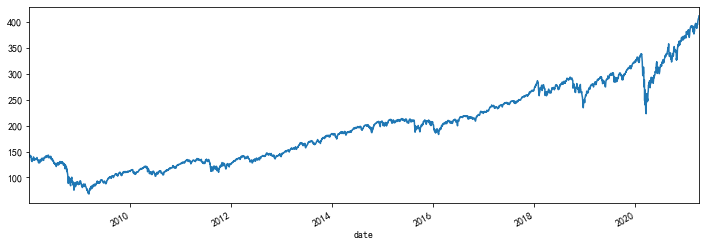

In [110]:
symbol = "SPY"
stock_us_daily_df = ak.stock_us_daily(symbol=symbol, adjust="")

f, ax = plt.subplots(figsize=(12, 4))
stock_us_daily_df[stock_us_daily_df.index.year >= 2008]['close'].plot(ax=ax)

## Compare buying strategy for one stock

In [ ]:
fix_buys = []
model_buys = []
model_buys_next_q = []
for ds, i in df.iterrows():
    # buy each quarter
    fix_buys.append(i.stock_price)
    if i.stock_price < i.predictions:
        # buy only if price is lower than predictions
        model_buys.append(i.stock_price)
    if i.price_next_q < i.predictions:
        # buy only if next q price is lower than predictions
        model_buys_next_q.append(i.stock_price)
        
print(sum(fix_buys), np.mean(fix_buys), len(fix_buys))
print(sum(model_buys), np.mean(model_buys), len(model_buys))
print(sum(model_buys_next_q), np.mean(model_buys_next_q), len(model_buys_next_q))

# PE PB (04/16/2021)

## load and process sp500 data

In [101]:
df_pepb = pd.read_csv('sp500_1_300_history_filterd.csv', index_col=0)

In [126]:
# replace inf pe or pb to 0
df_pepb = df_pepb.replace(np.inf, 0)

In [148]:
# remove stocks with over 20 quarters with neg equity
df_pb_neg = df_pepb[df_pepb.price_to_book_ratio < 0].groupby('stock').size()
stocks_pb_neg = df_pb_neg[df_pb_neg >= 20].index.values
df_pepb = df_pepb[~df_pepb.stock.isin(stocks_pb_neg)]

## get pepb quantiles

In [150]:
df_pepb['pepb'] = df_pepb['pe_ratio'] * df_pepb['price_to_book_ratio']

In [176]:
def q05(x):
    return x.quantile(0.05)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
def q95(x):
    return x.quantile(0.95)
f = {'pepb': [q05, q25, 'median', q75, q95]}
df_pepb_g = df_pepb[df_pepb.index != '2021Q2'].groupby('stock').agg(f)

In [178]:
df_pepb_g.columns = [f'pepb_{i}' for i in df_pepb_g.columns.get_level_values(1).values]

## get pepb last year

In [196]:
df_pepb_last_year = df_pepb[df_pepb.year == 2020].groupby('stock')['pepb'].mean()
df_pepb_last_year.name = 'pepb_last_year'

## Check current pepb level

In [197]:
df_pepb_stats = pd.merge(df_pepb[df_pepb.index == '2021Q2'], df_pepb_g, on='stock')
df_pepb_stats = pd.merge(df_pepb_stats, df_pepb_last_year, on='stock')

In [201]:
def get_pepb_note(x):
    note = None
    if x['pepb'] == 0:
        note = 'negtive pepb'
    elif x['pepb'] >= x['pepb_q95']:
        note = 'over q95'
    elif x['pepb'] < x['pepb_q75']:
        note = 'under q75'
    else:
        note = 'over q75, under q95'
    sub = '; over last year' if x['pepb'] > x['pepb_last_year'] else '; under last year'
    return note + sub
df_pepb_stats['pepb_note'] = df_pepb_stats.apply(get_pepb_note, axis=1)

In [202]:
df_pepb_stats[df_pepb_stats.stock.isin(all_stocks)].sort_values('pepb_note').drop(['date', 'ttm_net_eps', 'book_value_per_share', 'year'], axis=1)

,stock_price,pe_ratio,price_to_book_ratio,stock,pepb,pepb_q05,pepb_q25,pepb_median,pepb_q75,pepb_q95,pepb_last_year,pepb_note
232,118.34,211.32,0.00,SBUX,0.0000,-668.525280,86.638300,177.56330,297.024000,404.06328,-1326.671025,negtive pepb; over last year
173,233.08,36.94,0.00,MCD,0.0000,-909.078800,-423.237100,42.93180,71.846600,195.73936,-499.929375,negtive pepb; over last year
39,238.69,27.82,0.00,BABA,0.0000,0.000000,0.000000,0.00000,0.000000,247.34583,25.861250,negtive pepb; under last year
90,187.26,0.00,3.76,DIS,0.0000,5.848000,22.200300,30.17010,52.357200,65.67994,14.769600,negtive pepb; under last year
159,53.68,29.99,11.35,KO,340.3865,32.855200,51.966225,71.08835,173.093075,599.00565,210.541900,"over q75, under q95; over last year"
11,88.55,19.94,2.12,AEP,42.2728,4.839600,7.701000,14.36850,28.528500,61.21880,38.637075,"over q75, under q95; over last year"
213,137.25,25.95,6.96,PG,180.6120,18.190520,25.748100,39.63040,70.562800,365.85092,216.316325,"over q75, under q95; under last year"
229,129.91,564.83,14.07,ROST,7947.1581,48.179320,68.071650,127.94700,198.628350,445.34142,592.809600,over q95; over last year
204,37.31,54.07,2.14,OHI,115.7098,4.728340,11.557000,19.61070,31.398400,65.38204,54.729425,over q95; over last year
187,260.74,38.86,15.11,MSFT,587.1746,25.583860,37.762000,65.04960,189.612800,437.76492,395.650100,over q95; over last year


# Earning

In [1]:
def get_earning(ticker, DAYS_AHEAD=-1900):
    # setting the dates
    start_date = (datetime.now().date() + timedelta(days=DAYS_AHEAD))
    end_date = datetime.now().date()

    # downloading the earnings calendar
    yec = YahooEarningsCalendar()
    earnings_list = yec.get_earnings_of(ticker)
    earnings_df = pd.DataFrame(earnings_list)

    # extracting the date from the string and filtering for the period of interest
    earnings_df['report_date'] = earnings_df['startdatetime'].apply(lambda x: dateutil.parser.isoparse(x).date())
    earnings_df = earnings_df.loc[earnings_df['report_date'].between(start_date, end_date)] \
                             .sort_values('report_date')

    return earnings_df

## Check how days before earning can predict price after

In [26]:
experiment_pe_stocks = ['AAPL', 'DIS', 'GOOGL', 'KO', 'MSFT', 'WMT',]

l_stock_pe = []
for symbol in ['MSFT','ROST','TSLA', 'BABA', 'TCEHY',]:  #experiment_pe_stocks:  # ['KO']:
    er_ds_df = get_earning(symbol)
    # er_ds_dict = {symbol: [pd.Timestamp(i) for i in er_ds_df.report_date.values]}
    er_ds = [pd.Timestamp(i) for i in er_ds_df.report_date.values]
    df_stock_price_for_er = ak.stock_us_daily(symbol=symbol, adjust="")

    day_hold_range = [16] # range(7, 25)
    for day_hold in day_hold_range:
        profit_sum = []
        is_positive = []
        for day_er in er_ds:
            er_ind = np.where(df_stock_price_for_er.index == day_er)[0][0]
            df_er = df_stock_price_for_er.iloc[er_ind - 2:er_ind + 40, :]
            df_er['close_prev_day'] = df_er['close'].shift(1)
            df_er['dip'] = (df_er['close'] - df_er['close_prev_day']) < 0
            df_er = df_er.iloc[1:day_hold, :]
            if df_er['dip'].values[0]:
                buy_price = df_er['close'].values[0]
                sell_price = df_er['close'].values[-1]
                gain = (sell_price - buy_price) / buy_price
                if len(day_hold_range) == 1:
                    print(f'Date: {df_er.index.values[0]}. Profit: {gain * 100:.3}%')
                profit_sum.append(gain)
                is_positive.append(gain > 0)
        avg_profit = (np.mean(profit_sum) * 100).round(3)
        print(f'{symbol}: Sell on the {day_hold - 2}th trading day; Avg profit: {avg_profit}%\n')
    l_stock_pe.append((symbol, avg_profit, np.mean(is_positive).round(2)))
    

Date: 2016-01-27T00:00:00.000000000. Profit: 2.34%
Date: 2016-04-20T00:00:00.000000000. Profit: -8.22%
Date: 2016-10-19T00:00:00.000000000. Profit: 5.11%
Date: 2017-04-26T00:00:00.000000000. Profit: 2.33%
Date: 2017-10-25T00:00:00.000000000. Profit: 6.89%
Date: 2018-01-30T00:00:00.000000000. Profit: -0.0216%
Date: 2018-04-25T00:00:00.000000000. Profit: 5.43%
Date: 2018-07-18T00:00:00.000000000. Profit: 3.58%
Date: 2018-10-23T00:00:00.000000000. Profit: -1.14%
Date: 2019-01-29T00:00:00.000000000. Profit: 5.08%
Date: 2019-07-17T00:00:00.000000000. Profit: -1.16%
Date: 2019-10-22T00:00:00.000000000. Profit: 7.14%
Date: 2020-04-28T00:00:00.000000000. Profit: 8.89%
Date: 2020-07-21T00:00:00.000000000. Profit: -0.24%
Date: 2020-10-26T00:00:00.000000000. Profit: 3.06%
MSFT: Sell on the 14th trading day; Avg profit: 2.605%

Date: 2016-02-29T00:00:00.000000000. Profit: 7.86%
Date: 2016-05-18T00:00:00.000000000. Profit: -1.58%
Date: 2018-03-05T00:00:00.000000000. Profit: -4.03%
Date: 2018-11-19T

In [25]:
df_er_gain = pd.DataFrame(l_stock_pe, columns=['stock', 'avg gain%', 'frac_pos' ])\
    .sort_values('avg gain%', ascending=False)
df_er_gain[df_er_gain['avg gain%'] > 1.2][df_er_gain['frac_pos'] >= 0.6]

c:\users\yuwei\tools\env\penv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,stock,avg gain%,frac_pos
10,OHI,5.799,0.75
6,FB,5.679,0.82
18,AAPL,5.360,0.82
12,WMT,4.884,0.71
4,CMCSA,4.019,0.77
7,GOOGL,3.001,0.60
11,COST,2.365,0.60
8,KO,1.557,0.67
16,EA,1.216,0.67


## Get future earning date for some stocks

In [29]:
def get_earning(ticker, DAYS_AHEAD=30):
    # setting the dates
    start_date = datetime.now().date()
    end_date = datetime.now().date() + timedelta(days=DAYS_AHEAD)

    # downloading the earnings calendar
    yec = YahooEarningsCalendar()
    earnings_list = yec.get_earnings_of(ticker)
    earnings_df = pd.DataFrame(earnings_list)

    # extracting the date from the string and filtering for the period of interest
    earnings_df['report_date'] = earnings_df['startdatetime'].apply(lambda x: dateutil.parser.isoparse(x).date())
    earnings_df = earnings_df.loc[earnings_df['report_date'].between(start_date, end_date)] \
                             .sort_values('report_date')
    earnings_df['er_day'] = earnings_df['report_date'].apply(lambda x: f"{x.month:02}/{x.day:02}")

    return earnings_df

In [30]:
df_er_select = pd.DataFrame()

all_stocks = ['AEP','BABA','CMCSA','EXPE','GOOG','KO','NFLX','OHI', 'COST', 'WMT', 'AMZN', 'MCD', 'SBUX', 'EA', 
              'PG','AAPL','DIS','EDU','MSFT','ROST','TSLA','TMO', 'JD']
experiment_pe_stocks = ['OHI', 'AAPL', 'WMT', 'CMCSA', 'GOOGL', 'MSFT', 'TCEHY', 'KO']  # old['AAPL', 'DIS', 'GOOGL', 'KO', 'MSFT', 'WMT',]

for symbol in experiment_pe_stocks:# all_stocks:
    df_er_select = df_er_select.append(get_earning(symbol, DAYS_AHEAD=100))
df_er_select = df_er_select.sort_values('report_date')

In [31]:
df_er_select['er_day'] = df_er_select['report_date'].apply(lambda x: f"{x.month:02}/{x.day:02}")

In [32]:
df_er_select[['ticker', 'er_day']].T

# half_len = len(df_er_select) // 2
# display(df_er_select[['ticker', 'er_day']].iloc[:half_len, :].T)
# display(df_er_select[['ticker', 'er_day']].iloc[half_len:, :].T)

,3,3,3,3,3,3,3
ticker,KO,GOOGL,MSFT,AAPL,CMCSA,OHI,WMT
er_day,04/19,04/26,04/27,04/28,04/29,05/03,05/18


In [11]:
get_earning('GOOGL', DAYS_AHEAD=100)

,ticker,companyshortname,startdatetime,startdatetimetype,epsestimate,epsactual,epssurprisepct,timeZoneShortName,gmtOffsetMilliSeconds,quoteType,report_date,er_day
3,GOOGL,Alphabet Inc,2021-04-26T20:00:00.000Z,AMC,15.85,NaN,NaN,EDT,-14400000,EQUITY,2021-04-26,04/26


# TODO-backtest the 6m + pb strategy

In [203]:
df_stock_sub.head()

,date,stock_price,ttm_net_eps,pe_ratio,book_value_per_share,price_to_book_ratio,stock,year
quarter,,,,,,,,
2006Q4,2006-10-31,23.59,$6.99,3.37,$8.94,2.64,A,2006
2006Q4,2006-10-31,21.91,$1.49,14.70,$10.05,2.18,ADI,2006
2006Q4,2006-10-31,36.75,$1.13,32.52,$4.33,8.49,ADSK,2006
2006Q4,2006-10-31,13.30,$0.98,13.57,$4.78,2.78,AMAT,2006
2006Q4,2006-10-31,10.95,$0.72,15.23,$3.03,3.61,BF.B,2006


# Build a regression model on some features

features:  
https://www.valuesignals.com/Quantitative_Value_Investing_In_Europe/Index#Conclusion

# test

# bakcup 

In [109]:
er_ds_dict = {'AAPL': [pd.Timestamp('2018-02-01'),
         pd.Timestamp('2018-05-01'),
         pd.Timestamp('2018-07-31'),
         pd.Timestamp('2018-11-01'),
         pd.Timestamp('2019-01-29'),
         pd.Timestamp('2019-04-30'),
         pd.Timestamp('2019-07-30'),
         pd.Timestamp('2019-10-30'),
         pd.Timestamp('2020-01-29'),
         pd.Timestamp('2020-04-30'),
         pd.Timestamp('2020-07-30'),
         pd.Timestamp('2020-10-29'),
        ],
  }

# df_stock_price_for_er = ak.stock_us_daily(symbol=symbol, adjust="")


In [2]:
# old M2 From https://fred.stlouisfed.org/series/M2
# new M2, weekly non season-adjusted - https://fred.stlouisfed.org/series/WM2NS
m2_weekly = pd.read_csv('M2SL.csv')
m2_weekly['DATE'] = pd.to_datetime(m2_weekly['DATE'])
m2_weekly['dayofyear'] = m2_weekly['DATE'].dt.dayofyear
m2_weekly['year'] = m2_weekly['DATE'].dt.year

def flat_doy(x):
    if x <= 90:
        x = 90
    elif x <= 181:
        x = 181
    elif x <= 273:
        x = 273
    else:
        x = 365
    return x
m2_weekly['flat_doy'] = m2_weekly['dayofyear'].apply(flat_doy)

m2_quarterly = m2_weekly.groupby(['year', 'flat_doy'], as_index=False)['M2'].mean()
m2_quarterly = m2_quarterly[m2_quarterly.year.between(1981, 2020)]

In [ ]:
def get_stock_price(stock_symbol):
    
    # Get data and format date
    # Data from https://www.macrotrends.net/stocks/research
    stock_us_fundamental_df = ak.stock_us_fundamental(stock=stock_symbol, symbol="PE")
    stock_us_fundamental_df = stock_us_fundamental_df.sort_values('date').reset_index(drop=True)
    stock_us_fundamental_df = stock_us_fundamental_df.set_index('date')
    stock_us_fundamental_df['year'] = stock_us_fundamental_df.index.str[:4].astype(int)
    print(f"\n{stock_symbol}. Last quarter:\n{stock_us_fundamental_df.iloc[-2, :][['stock_price', 'ttm_net_eps']]}")
    
    # Cut the beginning to get full year
    year_start = stock_us_fundamental_df.year[0]
    qs_year_start = (stock_us_fundamental_df.year == year_start).sum()
    if qs_year_start < 4:
        stock_us_fundamental_df = stock_us_fundamental_df.iloc[qs_year_start:, :]
        year_start += 1
    
    # Match M2 and stock for last row
    m2_quarterly_cut = m2_quarterly[m2_quarterly.year >= year_start]
    if len(m2_quarterly_cut) == len(stock_us_fundamental_df) - 1:
        m2_quarterly_cut = m2_quarterly_cut.append(m2_quarterly_cut.iloc[-1, :])
    elif len(m2_quarterly_cut) < len(stock_us_fundamental_df) - 1:
          print(f"Length of m2: {len(m2_quarterly_cut)}; Length of stock: {len(stock_us_fundamental_df)}")
    # Drop years they don't match
    join_year = pd.merge(pd.DataFrame(m2_quarterly_cut.groupby('year').size()).reset_index(),
                         pd.DataFrame(stock_us_fundamental_df.groupby('year').size()).reset_index(),
                         on=['year'], how='left')
    drop_year = join_year[join_year['0_x'] != join_year['0_y']].year.values
    m2_quarterly_cut = m2_quarterly_cut[~m2_quarterly_cut.year.isin(drop_year)]
    stock_us_fundamental_df = stock_us_fundamental_df[~stock_us_fundamental_df.year.isin(drop_year)]
    # Add M2
    stock_us_fundamental_df['m2'] = m2_quarterly_cut['M2'].values
    
    # Get features
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].str[1:]
    stock_us_fundamental_df['ttm_net_eps'][stock_us_fundamental_df['ttm_net_eps'] == ''] = '0'
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].astype(float)
    
    stock_us_fundamental_df['ttm_net_eps_prev_q'] = stock_us_fundamental_df['ttm_net_eps'].shift(1)
    stock_us_fundamental_df['ttm_net_eps_delta'] = \
        stock_us_fundamental_df['ttm_net_eps'] - stock_us_fundamental_df['ttm_net_eps_prev_q']
    stock_us_fundamental_df['ttm_net_eps_delta_frac'] = \
        stock_us_fundamental_df['ttm_net_eps_delta'] / stock_us_fundamental_df['ttm_net_eps_prev_q']
    
    stock_us_fundamental_df['ttm_net_eps_norm'] = \
        stock_us_fundamental_df['ttm_net_eps'] / stock_us_fundamental_df['m2']

    # Get DV
    stock_us_fundamental_df['price_next_q'] = stock_us_fundamental_df['stock_price'].shift(-1)
    stock_us_fundamental_df['price_next_q_log'] = stock_us_fundamental_df['price_next_q'].apply(np.log10)
    stock_us_fundamental_df['stock_price_log'] = stock_us_fundamental_df['stock_price'].apply(np.log10)

    return stock_us_fundamental_df

def plot_predictions(stock_us_fundamental_df, y_name, stock_name=''):
    f, a = plt.subplots(figsize=(20, 6))
#     stock_us_fundamental_df['m2_normalized'] = stock_us_fundamental_df['m2'] /\
#         stock_us_fundamental_df['m2'].mean() * stock_us_fundamental_df[y_name].mean()
#     stock_us_fundamental_df['ttm_net_eps_normalized'] = stock_us_fundamental_df['ttm_net_eps'] /\
#         stock_us_fundamental_df['ttm_net_eps'].mean() * stock_us_fundamental_df[y_name].mean()
    stock_us_fundamental_df[[y_name, 'predictions', 
    #                          'm2_normalized', 'ttm_net_eps_normalized'
                            ]].plot(ax=a)
    dates = stock_us_fundamental_df.index.values
    a.set_xticks(range(len(dates)))
    a.set_xticklabels(dates, rotation=40, ha='right')
    a.grid(which='major', alpha=0.5)
    a.set_title(stock_name)